In [1]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
%load_ext autoreload
%autoreload 2

# Formatting your data: feature extraction from motion tracking output

##### Tutorial index:
    
* Create and run a project.
* Load a previously generated project.
* Interact with your project: generate coordinates, distances, angles, and areas.
* Exploratory visualizations: heatmaps, basic embeddings, and processed animations.
* Data preprocessing: generate datasets for machine learning.

### Create and run a project

Project creation should be more automatic. Specify a project path, a video and a tab path. Running the project should create the needed directories automatically, and store any further files in place to keep everything tidy! Shouldn't be much work.

In [3]:
# Create and run a project. Explore different processing parameters (smoothing, imputation)

In [22]:
my_deepof_project = deepof.data.Project(
                project_path=os.path.join("../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_OF/"),
                video_path=os.path.join("../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_OF/JB08_files_OF/Videos/"),
                table_path=os.path.join("../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_OF/JB08_files_OF/Tables/"),
                project_name="deepof_tutorial",
                arena="circular-autodetect",
           #     animal_ids=["B", "W"],
                video_format=".mp4",
                exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip"],
                video_scale=380,
                enable_iterative_imputation=1,
#                 exp_conditions={
#                     '20191204_Day2_SI_JB08_Test_56': 'Stressed',
#                     '20191204_Day2_SI_JB08_Test_61': 'Stressed',
#                     '20191204_Day2_SI_JB08_Test_62': 'Stressed',
#                     '20191204_Day2_SI_JB08_Test_54': 'Nonstressed',
#                     '20191204_Day2_SI_JB08_Test_63': 'Nonstressed',
#                     '20191204_Day2_SI_JB08_Test_64': 'Nonstressed'
#                 }
)

In [ ]:
my_deepof_project = my_deepof_project.create()

Setting up project directories...
Loading trajectories...
Smoothing trajectories...
Interpolating outliers...
Iterative imputation of ocluded bodyparts...


[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stoppi

Detecting arena...
Computing distances...
Computing angles...
Computing areas...


### Load a previously generated project

In [4]:
# Load a previously saved project
my_deepof_project = deepof.data.load_project("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial/")

In [ ]:
import networkx as nx
tt = my_deepof_project.get_graph_dataset(
    animal_id="mouse_black_tail"
)
my_deepof_project.deep_unsupervised_embedding(tt[0], nx.adjacency_matrix(tt[1]).todense(), epochs=1)

### Interact with your project: generate coordinates, distances, angles, and areas.

In [ ]:
# Get and plot coordinates, distances, angles, and areas. Try and visualizing different centering and rotations

In [19]:
my_deepof_project.get_angles()['20191204_Day2_SI_JB08_Test_54']

,"(B_Spine_1, B_Right_ear, B_Nose)","(B_Right_bhip, B_Spine_2, B_Center)","(B_Right_bhip, B_Spine_2, B_Left_bhip)","(B_Right_bhip, B_Spine_2, B_Tail_base)","(B_Center, B_Spine_2, B_Left_bhip)","(B_Center, B_Spine_2, B_Tail_base)","(B_Left_bhip, B_Spine_2, B_Tail_base)","(B_Right_ear, B_Spine_1, B_Center)","(B_Right_ear, B_Spine_1, B_Left_ear)","(B_Center, B_Spine_1, B_Left_ear)",...,"(W_Right_ear, W_Spine_1, W_Left_ear)","(W_Center, W_Spine_1, W_Left_ear)","(W_Spine_2, W_Center, W_Spine_1)","(W_Spine_2, W_Center, W_Left_fhip)","(W_Spine_2, W_Center, W_Right_fhip)","(W_Spine_1, W_Center, W_Left_fhip)","(W_Spine_1, W_Center, W_Right_fhip)","(W_Left_fhip, W_Center, W_Right_fhip)","(W_Spine_1, W_Left_ear, W_Nose)","(W_Right_ear, W_Nose, W_Left_ear)"
00:00:00,1.147930,1.450392,1.603127,2.174908,1.444523,1.917910,1.628905,1.601093,1.263285,1.011682,...,1.217084,1.087471,0.961855,1.011893,0.900149,1.121115,1.000882,0.992315,1.201283,1.219283
00:00:00.039935995,1.316944,1.431025,1.443029,1.505351,1.201857,1.261774,1.218781,1.342716,1.262164,1.351738,...,1.133904,1.148573,0.996811,1.049503,0.928166,1.082681,0.972840,1.016694,1.189042,1.266985
00:00:00.079871991,1.479350,1.595908,1.307737,1.334436,1.256418,1.283116,1.286575,1.131345,1.301318,1.366577,...,1.129943,1.152785,1.018414,1.008178,0.980195,1.055802,1.027819,1.080481,1.289870,1.187207
00:00:00.119807987,1.165251,1.438751,1.496156,2.134956,1.374172,1.871440,1.584399,1.595965,1.283110,1.040176,...,1.256596,1.115584,0.977661,1.023789,0.916400,1.156150,1.038956,1.029561,1.231578,1.248703
00:00:00.159743982,1.308756,1.429728,1.436690,1.500878,1.183573,1.244705,1.170952,1.344308,1.261812,1.325993,...,1.170519,1.189133,1.025556,1.078759,0.959449,1.116897,1.008373,1.054342,1.215281,1.303863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:09:58.800320021,1.051673,0.781365,0.732581,0.749164,0.682034,0.699771,0.637117,0.967917,0.939263,0.855670,...,0.026153,0.077788,0.093765,0.092797,0.099712,0.031241,0.035669,0.053375,0.060079,0.157224
00:09:58.840256017,1.205907,0.824560,0.745552,0.680651,0.709623,0.654674,0.614202,0.890538,1.075909,0.993133,...,0.048816,0.062928,0.090982,0.006744,0.124476,0.001961,0.104085,0.107010,0.107398,0.103861
00:09:58.880192012,1.077402,0.784469,0.721126,0.765130,0.725358,0.769362,0.692462,1.014061,1.072793,0.875838,...,0.014020,0.132222,0.046989,0.068914,0.029993,0.010771,0.088135,0.000745,0.127167,0.013809
00:09:58.920128008,1.064248,0.778946,0.729909,0.746072,0.684174,0.701978,0.640227,0.977633,0.951801,0.859763,...,0.046125,0.069335,0.087687,0.086945,0.091080,0.047575,0.051450,0.063957,0.044232,0.132484


In [5]:
my_deepof_project.get_coords(polar=True)['20191204_Day2_SI_JB08_Test_54']

B_Center           B_Left_bhip            B_Left_ear  \
                           rho       phi         rho       phi         rho   
00:00:00            289.338783  0.689772  300.804067  0.739869  254.099090   
00:00:00.039935995  289.235577  0.695360  300.684457  0.743472  253.533670   
00:00:00.079871991  288.667571  0.701278  299.326099  0.745871  254.176041   
00:00:00.119807987  286.080593  0.701839  295.821739  0.751640  253.762378   
00:00:00.159743982  285.356658  0.693722  293.588995  0.751676  255.752193   
...                        ...       ...         ...       ...         ...   
00:09:58.800320021  321.768984  1.227297  323.232941  1.165667  356.219911   
00:09:58.840256017  328.976478  1.234353  327.835009  1.171243  365.507339   
00:09:58.880192012  336.199649  1.241106  335.298106  1.189685  374.859886   
00:09:58.920128008  336.199649  1.241106  335.298106  1.189685  374.859886   
00:09:58.960064004  336.199649  1.241106  335.298106  1.189685  374.859886   

                             B_Left_fhip                B_Nose            ...  \
                         phi         rho       phi         rho       phi  ...   
00:00:00            0.715093  275.402442  0.748930  239.081438  0.663909  ...   
00:00:00.039935995  0.707073  275.885585  0.750112  243.196722  0.643591  ...   
00:00:00.079871991  0.679219  272.953354  0.742575  249.856076  0.606910  ...   
00:00:00.119807987  0.648975  270.001383  0.738567  255.621201  0.571579  ...   
00:00:00.159743982  0.629328  268.895731  0.722431  258.501405  0.543427  ...   
...                      ...         ...       ...         ...       ...  ...   
00:09:58.800320021  1.266952  339.895100  1.214500  372.213843  1.322861  ...   
00:09:58.840256017  1.280644  345.053692  1.214721  378.838413  1.321592  ...   
00:09:58.880192012  1.293655  354.938805  1.228842  386.860748  1.345021  ...   
00:09:58.920128008  1.293655  354.938805  1.228842  386.860748  1.345021  ...   
00:09:58.960064004  1.293655  354.938805  1.228842  386.860748  1.345021  ...   

                   W_Right_ear           W_Right_fhip             W_Spine_1  \
                           rho       phi          rho       phi         rho   
00:00:00            431.438428  0.362150   392.288452  0.339267  407.340197   
00:00:00.039935995  445.563956  0.363447   404.371135  0.352026  421.197787   
00:00:00.079871991  454.136244  0.368750   414.123402  0.354411  428.741701   
00:00:00.119807987  462.690684  0.371731   424.152167  0.356272  439.275049   
00:00:00.159743982  470.766070  0.380749   434.233605  0.353901  451.701879   
...                        ...       ...          ...       ...         ...   
00:09:58.800320021  527.843368  1.061716   545.631283  1.083224  534.107187   
00:09:58.840256017  527.754150  1.061763   545.573093  1.083159  534.016762   
00:09:58.880192012  527.784290  1.061916   545.609563  1.083258  534.033554   
00:09:58.920128008  527.784290  1.061916   545.609563  1.083258  534.033554   
00:09:58.960064004  527.784290  1.061916   545.609563  1.083258  534.033554   

                               W_Spine_2           W_Tail_base            
                         phi         rho       phi         rho       phi  
00:00:00            0.320949  365.525759  0.286595  335.849920  0.294879  
00:00:00.039935995  0.326299  371.232209  0.294919  346.763803  0.289038  
00:00:00.079871991  0.327451  384.591698  0.297852  365.145540  0.280677  
00:00:00.119807987  0.330754  394.556560  0.295014  375.795160  0.274648  
00:00:00.159743982  0.328099  405.216631  0.296351  384.117598  0.280794  
...                      ...         ...       ...         ...       ...  
00:09:58.800320021  1.100073  568.404468  1.107500  582.960077  1.093313  
00:09:58.840256017  1.100112  568.424169  1.107615  582.951339  1.093385  
00:09:58.880192012  1.100232  568.502595  1.107555  583.028542  1.093248  
00:09:58.920128008  1.100232  568.502595  1.107555  583.028542  1.093248  
00:09:58.960064004  1.100

In [ ]:
my_deepof_project.deep_unsupervised_embedding()

In [ ]:
my_deepof_project.get_distances()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_angles()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_areas()

In [ ]:
my_deepof_project.get_areas()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
# Show how to merge different feature objects

my_deepof_project.get_coords().pca()

### Exploratory visualizations: heatmaps, basic embeddings, and processed animations.

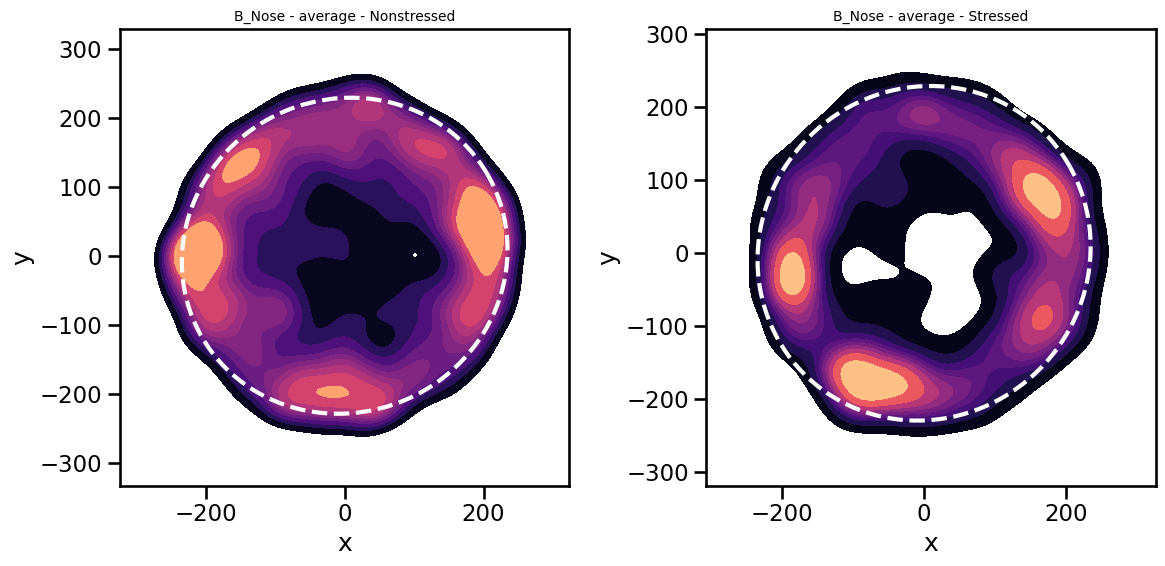

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import deepof.visuals
from matplotlib.patches import Ellipse

sns.set_context("talk")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="Nonstressed",
    ax=ax1,
    show=False,
    display_arena=True,
    experiment_id="average",
)

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="Stressed",
    ax=ax2,
    show=False,
    display_arena=True,
    experiment_id="average",
)

plt.tight_layout()
plt.show()

In [ ]:
# Create a preprocessed version of the dataset we're after
pp, _, _ = my_deepof_project.get_graph_dataset(
  #  animal_id="B",
    center="Center",
    align="Spine_1",
    preprocess=True,
    scale="robust",
)

In [ ]:
pp[2]

In [ ]:
from ipywidgets import interact, IntSlider

@interact()
def plot_mouse(i=IntSlider(min=0, max=100)):

    sns.scatterplot(x=pp[0][i][0][:11], y=pp[0][i][0][22:33])
    sns.scatterplot(x=pp[0][i][0][11:22], y=pp[0][i][0][33:44])
#     sns.scatterplot(x=pp[0][15000 + i][0][:11], y=pp[0][15000 + i][0][11:22])
#     sns.scatterplot(x=pp[0][30000 + i][0][:11], y=pp[0][30000 + i][0][11:22])
#     sns.scatterplot(x=pp[0][45000 + i][0][:11], y=pp[0][45000 + i][0][11:22])
#     sns.scatterplot(x=pp[0][60000 + i][0][:11], y=pp[0][60000 + i][0][11:22])
#     sns.scatterplot(x=pp[0][75000 + i][0][:11], y=pp[0][75000 + i][0][11:22])
    
    plt.xlim(-3, 3)
    plt.ylim(-4, 5)
    
    plt.show()

In [ ]:
ss = (pp[0][:25000], pp[1][:25000], pp[2][:25000], pp[3][:25000], pp[4][:25000], pp[5][:25000])

In [ ]:
%%time
cons = my_deepof_project.deep_unsupervised_embedding(
    preprocessed_data,
    embedding_model="VaDE",
    epochs=5,
    encoder_type="TCN",
    n_components=15,
    batch_size=128,
    latent_dim=2,
    kl_warmup=10,
    kl_annealing_mode="linear",
    kmeans_loss=0.0,
    reg_cat_clusters=0.0,
)

In [ ]:
tt = cons.encoder([ss[0], ss[1]])
qq = cons.grouper([ss[0], ss[1]])

In [ ]:
import umap
umap = tt.numpy()#umap.UMAP(n_components=2, n_neighbors=250).fit_transform(tt.numpy())

In [ ]:
means = cons.get_gmm_params['means'].numpy()

sns.scatterplot(x=umap[:, 0], y=umap[:, 1], hue=qq.numpy().argmax(axis=1), palette="tab20")
means = cons.get_layer("grouper").get_layer("gaussian_mixture_latent").c_mu.numpy()
sns.scatterplot(x=means[:,0], y=means[:,1], s=250, c="black")

plt.title("VQVAE embeddings")

plt.legend("")
plt.show()

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    #embedding=emb,
    #cluster_assignments=clust_ass,
    #animal_id="W",
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    frame_limit=250,
    # selected_cluster=0,
    dpi=60,
    # center="Center",
    # align="Spine_1",
    #embedding=[emb_B, emb_W],
    save="SAB_multi_animal_example.mp4",
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
# Single animal display

In [ ]:
from sklearn.decomposition import PCA

emb = PCA(n_components=3).fit_transform(my_deepof_project.get_coords().filter_id("B")['20191204_Day2_SI_JB08_Test_56'])

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    animal_id="B",
    embedding=emb,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=750,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
emb = PCA(n_components=3).fit_transform(my_deepof_project.get_coords(center="Center", align="Spine_1").filter_id("B")['20191204_Day2_SI_JB08_Test_56'])

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    center="Center",
    align="Spine_1",
    animal_id="B",
    embedding=emb,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=750,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
# Get and plot coordinates, distances, angles, and areas. Try and visualizing different centering and rotations

In [ ]:
my_deepof_project.get_coords(polar=True)['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_distances()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_angles()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_areas()

In [ ]:
my_deepof_project.get_areas()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
# Show how to merge different feature objects

my_deepof_project.get_coords().pca()

### Data preprocessing: generate datasets for machine learning.

In [ ]:
import networkx as nx
from deepof.utils import connect_mouse_topview

G = connect_mouse_topview(animal_ids=["B", "W"], exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip"])

# Include a (nicer) version of this plot in the tutorial
nx.draw(G, 
        with_labels=True,
        pos=nx.spring_layout(G), 
        node_color=["red" if i.startswith("B") else "blue" for i in G.nodes()])